# Modelling
## Load data necessary for modelling

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc


# Load the CSVs
def load_and_display_data(file_name, name):
    data = pd.read_csv(file_name)
    print(f"{name} Data:")
    print(data.head(), "\n")
    return data

# Load the datasets
constructors = load_and_display_data('constructors.csv', 'Constructors')
drivers = load_and_display_data('drivers.csv', 'Drivers')
races = load_and_display_data('races.csv', 'Races')
results = load_and_display_data('results.csv', 'Results')

Constructors Data:
   constructorId constructorRef        name nationality  \
0              1        mclaren     McLaren     British   
1              2     bmw_sauber  BMW Sauber      German   
2              3       williams    Williams     British   
3              4        renault     Renault      French   
4              5     toro_rosso  Toro Rosso     Italian   

                                                 url  
0               http://en.wikipedia.org/wiki/McLaren  
1            http://en.wikipedia.org/wiki/BMW_Sauber  
2  http://en.wikipedia.org/wiki/Williams_Grand_Pr...  
3  http://en.wikipedia.org/wiki/Renault_in_Formul...  
4   http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso   

Drivers Data:
   driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  19

## Preprocessing
### Races
#### Extract only the relevant columns: raceid, year, round, circuitid

In [2]:
races = races[["raceId", "year", "round", "circuitId"]]

races.head()

,raceId,year,round,circuitId
0,1,2009,1,1
1,2,2009,2,2
2,3,2009,3,17
3,4,2009,4,3
4,5,2009,5,4


### Results
#### Extract only the relevant columns

In [3]:
results = results[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']]

results.head()

,raceId,driverId,constructorId,grid,positionOrder
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


### Merging results and races

In [4]:
df = pd.merge(races, results, on='raceId')

df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder
0,1,2009,1,1,18,23,1,1
1,1,2009,1,1,22,23,2,2
2,1,2009,1,1,15,7,20,3
3,1,2009,1,1,10,7,19,4
4,1,2009,1,1,4,4,10,5


### Creating a column for top 3

In [5]:
# Creating a column for Top 3 Finish
df['Top 3 Finish'] = (df['positionOrder'] <= 3).astype(int)

df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish
0,1,2009,1,1,18,23,1,1,1
1,1,2009,1,1,22,23,2,2,1
2,1,2009,1,1,15,7,20,3,1
3,1,2009,1,1,10,7,19,4,0
4,1,2009,1,1,4,4,10,5,0


## Feature engineering
### Driver Top 3 Finish Percentage Previous Year

In [6]:
def calculate_driver_top_3_finish_percentage_last_year(df):
    # Calculate total races, top 3 finishes, and top 3 finish percentage for each driver in each year
    driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
        Total_Races=('raceId', 'nunique'),
        Top_3_Finishes=('Top 3 Finish', 'sum')
    ).assign(
        Driver_Top_3_Finish_Percentage_This_Year=lambda x: (x['Top_3_Finishes'] / x['Total_Races'] * 100)
    ).reset_index()

    # Shift 'year' to create last year's stats
    driver_yearly_stats['year'] += 1
    driver_yearly_stats = driver_yearly_stats[['year', 'driverId', 'Driver_Top_3_Finish_Percentage_This_Year']].rename(
        columns={'Driver_Top_3_Finish_Percentage_This_Year': 'Driver_Top_3_Finish_Percentage_Last_Year'})

    # Merge the last year's percentages into the original dataframe
    df_merged = pd.merge(df, driver_yearly_stats, on=['year', 'driverId'], how='left')

    return df_merged

### Constructor Top 3 Finish Percentage Previous Year

In [7]:
def calculate_constructor_top_3_finish_percentage_last_year(df):
    # Group by year, constructor, and round to calculate the mean top 3 finish percentage for each constructor
    constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
        Constructor_Top_3_Finish_Percentage_Last_Year=('Driver_Top_3_Finish_Percentage_Last_Year', 'mean')
    ).reset_index()

    # Merge the calculated constructor stats back into the original dataframe
    df_merged = pd.merge(
        df, 
        constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor_Top_3_Finish_Percentage_Last_Year']], 
        on=['year', 'constructorId', 'round'], 
        how='left'
    )

    return df_merged

### Driver's average finishing position for previous year

In [8]:
def calculate_driver_avg_position_last_year(df):
    # Group by year and driver to calculate the total races and average position for each driver in the current year
    driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
        Total_Races=('raceId', 'nunique'),
        Driver_Avg_Position_This_Year=('positionOrder', 'mean')
    ).reset_index()

    # Shift the year forward by 1 to represent last year's stats
    driver_yearly_stats['year'] += 1

    # Rename the column to indicate it contains last year's average position
    driver_yearly_stats = driver_yearly_stats[['year', 'driverId', 'Driver_Avg_Position_This_Year']].rename(
        columns={'Driver_Avg_Position_This_Year': 'Driver_Avg_Position_Last_Year'})

    # Merge the calculated last year's stats back into the original dataframe
    df_merged = pd.merge(df, driver_yearly_stats, on=['year', 'driverId'], how='left')

    return df_merged

### Constructor's average finishing position for previous year

In [9]:
def calculate_constructor_avg_position_last_year(df):
    # Group by year, constructor, and round to calculate the mean of drivers' average positions from last year
    constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
        Constructor_Avg_Position_Last_Year=('Driver_Avg_Position_Last_Year', 'mean')
    ).reset_index()

    # Merge the calculated constructor stats back into the original dataframe
    df_merged = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor_Avg_Position_Last_Year']],
                         on=['year', 'constructorId', 'round'], how='left')

    return df_merged

### Driver's average finishing position for current year

In [10]:
def calculate_driver_avg_position_current_year(df):
    def avg_position(row):
        # Filter for previous races in the same year and same driver but earlier rounds
        previous_races = df[(df['year'] == row['year']) & 
                            (df['driverId'] == row['driverId']) & 
                            (df['round'] < row['round'])]

        # If no previous races, return NA
        if previous_races.empty:
            return pd.NA

        # Calculate total races and sum of positions
        total_races = previous_races['raceId'].nunique()
        position_sum = previous_races['positionOrder'].sum()

        # Return average position if valid, else NA
        return position_sum / total_races if total_races > 0 else pd.NA

    # Apply the function to each row and create a new column
    df['Driver_Average_Position_This_Year'] = df.apply(avg_position, axis=1)

    return df

### Constructor's average finishing position for current year

In [11]:
def calculate_constructor_avg_position_current_year(df):
    # Group by year, constructor, and round to calculate the average position for each constructor this year
    constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
        Constructor_Avg_Position_This_Year=('Driver_Average_Position_This_Year', 'mean')
    ).reset_index()

    # Merge the calculated constructor stats back into the original dataframe
    df_merged = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor_Avg_Position_This_Year']],
                         on=['year', 'constructorId', 'round'], how='left')

    return df_merged

### Driver's win percentage previous year

In [12]:
def calculate_driver_win_percentage_last_year(df):
    # Add a 'Win' column, where 1 indicates a win (positionOrder = 1), else 0
    df['Win'] = (df['positionOrder'] == 1).astype(int)

    # Create a temporary dataframe with the previous year information
    df_temp = df.copy()
    df_temp['previous_year'] = df_temp['year'] - 1
    
    # Group by the previous year and driverId to calculate the win percentage
    driver_win_percentage_last_year = df_temp.groupby(['previous_year', 'driverId']).agg(
        Driver_Win_Percentage_Last_Year=('Win', 'mean')
    ).reset_index()

    # Convert win percentage to percentage format (multiply by 100)
    driver_win_percentage_last_year['Driver_Win_Percentage_Last_Year'] *= 100

    # Merge the calculated win percentage back into the original dataframe without adding the 'previous_year' column
    df_merged = pd.merge(df, driver_win_percentage_last_year[['previous_year', 'driverId', 'Driver_Win_Percentage_Last_Year']],
                         left_on=['year', 'driverId'], right_on=['previous_year', 'driverId'], how='left')

    # Return the final merged df
    return df_merged.drop(columns=['previous_year'])

### Constructor's win percentage previous year

In [13]:
def calculate_constructor_win_percentage_last_year(df):
    # Add a 'Win' column, where 1 indicates a win (positionOrder = 1), else 0
    df['Win'] = (df['positionOrder'] == 1).astype(int)

    # Create a temporary dataframe with the previous year information
    df_temp = df.copy()
    df_temp['previous_year'] = df_temp['year'] - 1
    
    # Group by the previous year and constructorId to calculate the win percentage
    constructor_win_percentage_last_year = df_temp.groupby(['previous_year', 'constructorId']).agg(
        Constructor_Win_Percentage_Last_Year=('Win', 'mean')
    ).reset_index()

    # Convert win percentage to percentage format (multiply by 100)
    constructor_win_percentage_last_year['Constructor_Win_Percentage_Last_Year'] *= 100

    # Merge the calculated win percentage back into the original dataframe without adding the 'previous_year' column
    df_merged = pd.merge(df, constructor_win_percentage_last_year[['previous_year', 'constructorId', 'Constructor_Win_Percentage_Last_Year']],
                         left_on=['year', 'constructorId'], right_on=['previous_year', 'constructorId'], how='left')

    # Return the final merged df
    return df_merged.drop(columns=['previous_year'])

### Driver's win percentage current year

In [14]:
def calculate_driver_win_percentage_current_year(df):
    # Add a 'Win' column, where 1 indicates a win (positionOrder = 1), else 0
    df['Win'] = (df['positionOrder'] == 1).astype(int)

    # Group by the current year and driverId to calculate the win percentage
    driver_win_percentage_this_year = df.groupby(['year', 'driverId']).agg(
        Driver_Win_Percentage_This_Year=('Win', 'mean')
    ).reset_index()

    # Convert win percentage to percentage format (multiply by 100)
    driver_win_percentage_this_year['Driver_Win_Percentage_This_Year'] *= 100

    # Merge the calculated win percentage back into the original dataframe
    df_merged = pd.merge(df, driver_win_percentage_this_year[['year', 'driverId', 'Driver_Win_Percentage_This_Year']],
                         on=['year', 'driverId'], how='left')

    # Return the final merged dataframe
    return df_merged

### Constructor's win percentage current year

In [15]:
def calculate_constructor_win_percentage_current_year(df):
    # Add a 'Win' column, where 1 indicates a win (positionOrder = 1), else 0
    df['Win'] = (df['positionOrder'] == 1).astype(int)

    # Group by the current year and constructorId to calculate the win percentage
    constructor_win_percentage_this_year = df.groupby(['year', 'constructorId']).agg(
        Constructor_Win_Percentage_This_Year=('Win', 'mean')
    ).reset_index()

    # Convert win percentage to percentage format (multiply by 100)
    constructor_win_percentage_this_year['Constructor_Win_Percentage_This_Year'] *= 100

    # Merge the calculated win percentage back into the original dataframe
    df_merged = pd.merge(df, constructor_win_percentage_this_year[['year', 'constructorId', 'Constructor_Win_Percentage_This_Year']],
                         on=['year', 'constructorId'], how='left')

    # Return the final merged dataframe
    return df_merged

### Call functions for feature engineering

In [16]:
# Call all the functions and print the df at the end

df = calculate_driver_top_3_finish_percentage_last_year(df)
df = calculate_constructor_top_3_finish_percentage_last_year(df)
df = calculate_driver_avg_position_last_year(df)
df = calculate_constructor_avg_position_last_year(df)
df = calculate_driver_avg_position_current_year(df)
df = calculate_constructor_avg_position_current_year(df)
df = calculate_driver_win_percentage_last_year(df)
df = calculate_constructor_win_percentage_last_year(df)
df = calculate_driver_win_percentage_current_year(df)
df = calculate_constructor_win_percentage_current_year(df)

# Print the updated dataframe
df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver_Top_3_Finish_Percentage_Last_Year,Constructor_Top_3_Finish_Percentage_Last_Year,Driver_Avg_Position_Last_Year,Constructor_Avg_Position_Last_Year,Driver_Average_Position_This_Year,Constructor_Avg_Position_This_Year,Win,Driver_Win_Percentage_Last_Year,Constructor_Win_Percentage_Last_Year,Driver_Win_Percentage_This_Year,Constructor_Win_Percentage_This_Year
0,1,2009,1,1,18,23,1,1,1,0.000000,2.777778,13.722222,13.805556,<NA>,NaN,1,10.526316,NaN,35.294118,23.529412
1,1,2009,1,1,22,23,2,2,1,5.555556,2.777778,13.888889,13.805556,<NA>,NaN,0,0.000000,NaN,11.764706,23.529412
2,1,2009,1,1,15,7,20,3,1,5.555556,5.555556,9.500000,9.972222,<NA>,NaN,0,0.000000,NaN,0.000000,0.000000
3,1,2009,1,1,10,7,19,4,0,5.555556,5.555556,10.444444,9.972222,<NA>,NaN,0,0.000000,NaN,0.000000,0.000000
4,1,2009,1,1,4,4,10,5,0,16.666667,11.111111,7.444444,10.250000,<NA>,NaN,0,26.315789,0.0,0.000000,0.000000


### We drop information related to the result of this race (e.g. finishing position) from the dataframe to prevent data leakage and also drop nans

In [17]:
df = df.drop(labels=["raceId"], axis=1)

# Drop rows with NaN values
df = df.dropna()

df.head()

,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver_Top_3_Finish_Percentage_Last_Year,Constructor_Top_3_Finish_Percentage_Last_Year,Driver_Avg_Position_Last_Year,Constructor_Avg_Position_Last_Year,Driver_Average_Position_This_Year,Constructor_Avg_Position_This_Year,Win,Driver_Win_Percentage_Last_Year,Constructor_Win_Percentage_Last_Year,Driver_Win_Percentage_This_Year,Constructor_Win_Percentage_This_Year
25,2009,2,2,17,9,5,6,0,0.000000,2.777778,10.000000,10.750000,12.0,12.5,0,21.052632,23.684211,11.764706,17.647059
26,2009,2,2,1,1,12,7,0,55.555556,36.111111,5.222222,6.555556,20.0,19.5,0,15.789474,13.157895,11.764706,5.882353
27,2009,2,2,3,3,4,8,0,11.111111,5.555556,10.888889,11.777778,6.0,12.0,0,0.000000,0.000000,0.000000,0.000000
28,2009,2,2,13,6,16,9,0,55.555556,52.777778,6.055556,6.527778,16.0,15.5,0,0.000000,13.157895,0.000000,2.941176
30,2009,2,2,4,4,9,11,0,16.666667,11.111111,7.444444,10.250000,5.0,11.0,0,26.315789,0.000000,0.000000,0.000000


### Correlation matrix

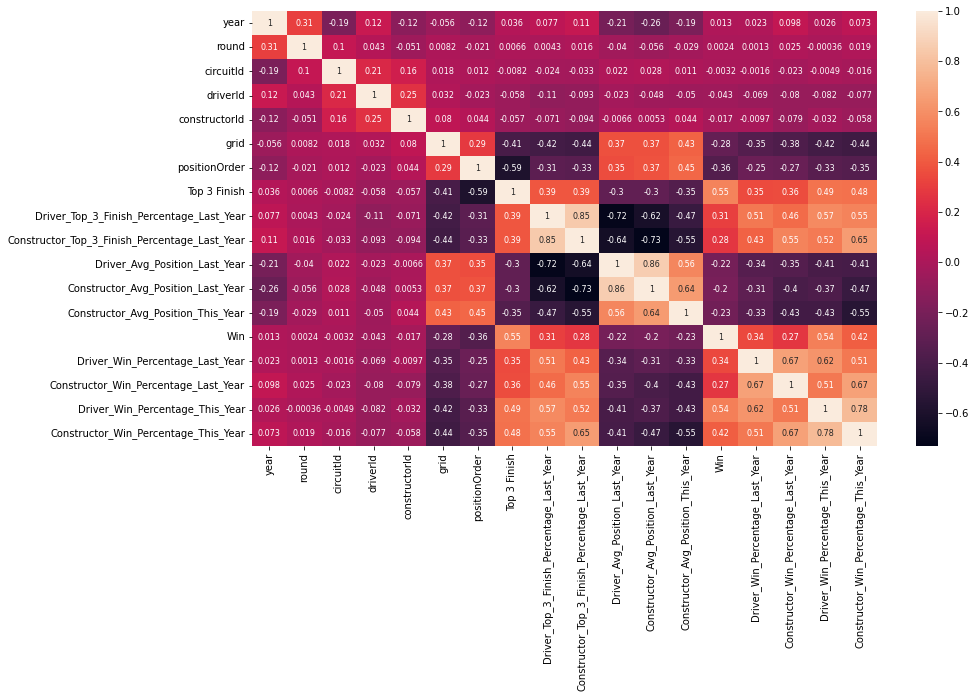

In [18]:
# heatmap
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 8})
plt.show()

 ### One hot encoding

In [19]:
df = pd.get_dummies(df, columns=['circuitId', 'constructorId'])
df = df.drop(["positionOrder"], axis = 1)

# Create a list of columns excluding the one to move
cols = [col for col in df.columns if col != 'Top 3 Finish']

# Append the column to the end of the DataFrame
df = df[cols + ['Top 3 Finish']]

## Modelling
### Predicting F1 podiums

In [20]:
feature_columns = [col for col in df.columns if col != 'Top 3 Finish']

# Splitting train, validation, and test sets
train_df = df[(df["year"] >= 1983) & (df["year"] <= 2009)]
val_df = df[(df["year"] >= 2010) & (df["year"] <= 2017)]
test_df = df[(df["year"] >= 2018) & (df["year"] <= 2024)]

# Prepare feature matrices and target variables
X_train = train_df[feature_columns].values
y_train = train_df['Top 3 Finish'].values

X_val = val_df[feature_columns].values
y_val = val_df['Top 3 Finish'].values

X_test = test_df[feature_columns].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


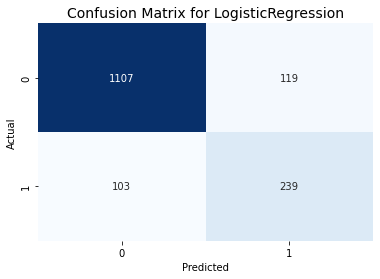

AUC-ROC: 0.9085, Accuracy: 0.8584, Precision: 0.6676, Recall: 0.6988, F1-Score: 0.6829
Model: KNeighborsClassifier
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


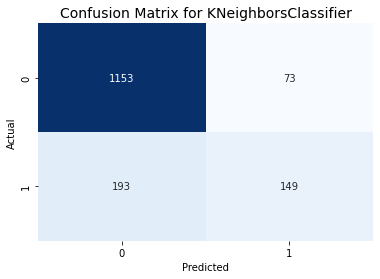

AUC-ROC: 0.8155, Accuracy: 0.8304, Precision: 0.6712, Recall: 0.4357, F1-Score: 0.5284
Model: RandomForestClassifier
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best parameters for RandomForestClassifier: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


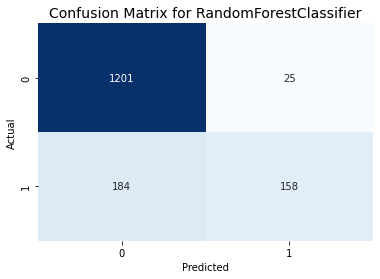

AUC-ROC: 0.9264, Accuracy: 0.8667, Precision: 0.8634, Recall: 0.4620, F1-Score: 0.6019
Model: DecisionTreeClassifier
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'min_samples_split': 2}


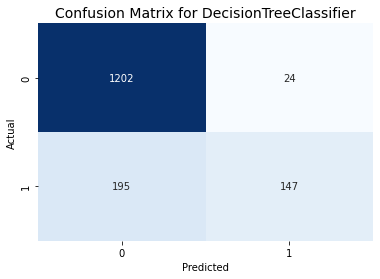

AUC-ROC: 0.9053, Accuracy: 0.8603, Precision: 0.8596, Recall: 0.4298, F1-Score: 0.5731
Model: StackedModel


C:\Users\alanm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alanm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

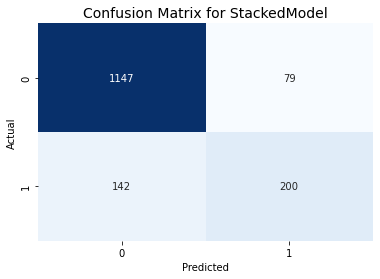

AUC-ROC: 0.9135, Accuracy: 0.8591, Precision: 0.7168, Recall: 0.5848, F1-Score: 0.6441


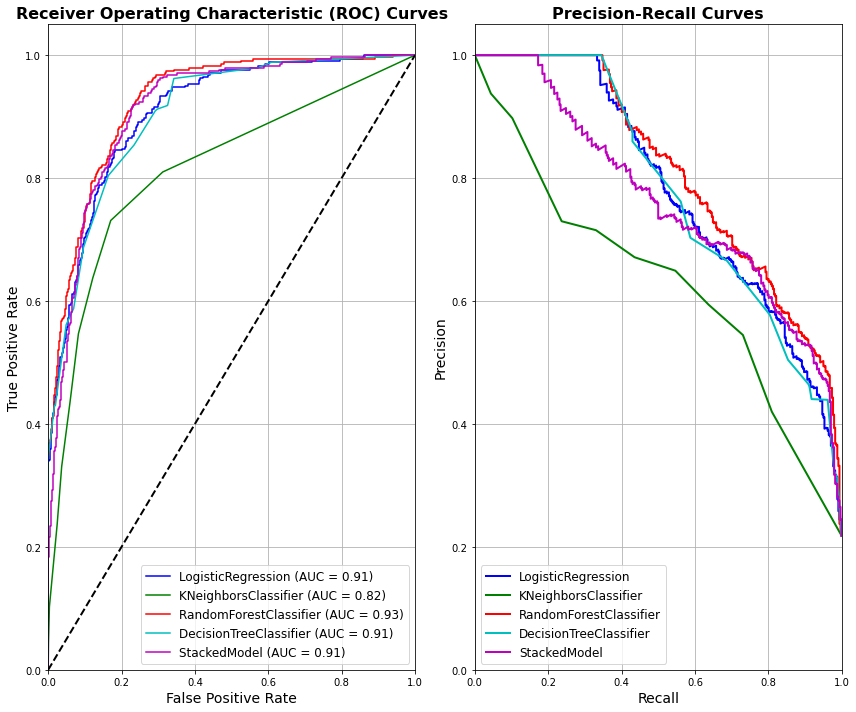

In [23]:
# Define parameter grids for each model
param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'p': [1, 2]
    },
    'RandomForestClassifier': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10]
    },
    'DecisionTreeClassifier': {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10]
    }
}

# Initialize base models for stacking
logistic_model = LogisticRegression(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)

# Initialize models, including StackedModel
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'StackedModel': StackingClassifier(
        estimators=[
            ('logistic', logistic_model), 
            ('random_forest', random_forest_model)
        ],
        final_estimator=LogisticRegression(random_state=42)  # Meta-model
    )
}

model_accuracy_info = {}

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to evaluate models
def evaluate_model(model, name, X_test, y_test):
    pred_test_proba = model.predict_proba(X_test)[:, 1]
    pred_test_class = (pred_test_proba >= 0.5).astype(int)

    # Calculate various evaluation metrics
    metrics = {
        'auc_roc': roc_auc_score(y_test, pred_test_proba),
        'accuracy': accuracy_score(y_test, pred_test_class),
        'precision': precision_score(y_test, pred_test_class),
        'recall': recall_score(y_test, pred_test_class),
        'f1_score': f1_score(y_test, pred_test_class),
        'confusion_matrix': confusion_matrix(y_test, pred_test_class)
    }
    
    # Plot the confusion matrix
    plot_confusion_matrix(metrics['confusion_matrix'], name)

    return metrics

# Hyperparameter tuning using GridSearchCV
for name, model in models.items():
    print(f"Model: {name}")
    
    # Perform grid search for models that have hyperparameters to tune
    if name in param_grids:
        # Use 'recall' as the scoring metric
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=10, scoring='f1', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")

        # Store the best model in the models dictionary for later use
        models[name] = best_model
    else:
        # For StackedModel
        model.fit(X_train, y_train)
        best_model = model

    # Evaluate the best model on test data
    metrics = evaluate_model(best_model, name, X_test, y_test)

    print(f"AUC-ROC: {metrics['auc_roc']:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1_score']:.4f}")

    # Save the model
    model_filename = f"{name}_model_V4.joblib"
    joblib.dump(best_model, model_filename)
    
    model_accuracy_info[name] = {'model': model_filename, **metrics}

# Plotting ROC and Precision-Recall Curves
plt.figure(figsize=(12, 10))  # Larger figure size
colors = ['b', 'g', 'r', 'c', 'm']  # Define distinct colors for each model
markers = ['o', 's', 'D', 'P', '*']  # Define markers for each model

# ROC Curve subplot
plt.subplot(1, 2, 1)
for i, (name, info) in enumerate(model_accuracy_info.items()):
    fpr, tpr, _ = roc_curve(y_test, models[name].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color=colors[i % len(colors)], label=f'{name} (AUC = {info["auc_roc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal dashed line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

# Precision-Recall Curve subplot
plt.subplot(1, 2, 2)
for i, (name, info) in enumerate(model_accuracy_info.items()):
    precision, recall, _ = precision_recall_curve(y_test, models[name].predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, color=colors[i % len(colors)], label=f'{name}', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves', fontsize=16, fontweight='bold')
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)

plt.tight_layout()  # Adjust subplots for better layout
plt.show()

In [25]:
# Identify the best model based on F1-Score and get predictions
best_model = models[max(model_accuracy_info, key=lambda x: model_accuracy_info[x]['f1_score'])]
y_pred = (best_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)

# Update 'test_df' with predictions and driver names
test_df = test_df.assign(Predicted_Top_3_Finish=y_pred)
test_df = test_df.merge(drivers[['driverId', 'forename', 'surname']], on='driverId', how='left')
test_df['Driver Name'] = test_df['forename'] + ' ' + test_df['surname']

# Create the prediction DataFrame with cleaned column names
prediction_df = test_df[['year', 'round', 'Driver Name', 'Predicted_Top_3_Finish', 'Top 3 Finish']].rename(
    columns={'year': 'Year', 'round': 'Round', 'Predicted_Top_3_Finish': 'Predicted Top 3 Finish', 'Top 3 Finish': 'Actual Top 3 Finish'}
)

# User input for year and round
year_to_check, round_to_check = map(int, [input("Enter the year (e.g., 2021): "), input("Enter the round (e.g., 5): ")])

# Filter and display results for specified year and round
filtered_df = prediction_df.query('Year == @year_to_check and Round == @round_to_check').sort_values(
    by=['Predicted Top 3 Finish', 'Driver Name'], ascending=[False, True]
).reset_index(drop=True)

# Display or handle if no data is available
if filtered_df.empty:
    print(f"No data available for Year {year_to_check}, Round {round_to_check}.")
else:
    print(f"\nPredictions and Actual Results for Year {year_to_check}, Round {round_to_check}:")
    print(filtered_df.head(20))

Enter the year (e.g., 2021):  2023
Enter the round (e.g., 5):  5



Predictions and Actual Results for Year 2023, Round 5:
    Year  Round      Driver Name  Predicted Top 3 Finish  Actual Top 3 Finish
0   2023      5     Carlos Sainz                       1                    0
1   2023      5   Max Verstappen                       1                    1
2   2023      5     Sergio Pérez                       1                    1
3   2023      5  Alexander Albon                       0                    0
4   2023      5  Charles Leclerc                       0                    0
5   2023      5     Esteban Ocon                       0                    0
6   2023      5  Fernando Alonso                       0                    1
7   2023      5   George Russell                       0                    0
8   2023      5  Kevin Magnussen                       0                    0
9   2023      5     Lance Stroll                       0                    0
10  2023      5     Lando Norris                       0                    0
11  2023